# Put TNG data into format for cosmic integration with COMPAS

Cosmic integration in COMPAS currently uses analytical model for SFR (M&D 14) and for the metallicity distribution (skewed log normal, based on Neijssel+ 19). There are 4 SFR parameters and 5 dP/dlogZ parameters.

The SFR is calculated using the find_sfr function, which needs the redshifts as a list of floats at which the SFR will be evaluated, and the 4 parameters a,b,c,d. The SFR is then returned as a list of floats (corresponding to each redshift), in units of M_$\odot$/Gpc$^3$/yr.

The metallicity distribution (dP/dlogZ) is calculated using the find_metallicity_distribution function which needs both COMPAS information, the metallicity distribution parameters ($\mu_0, \mu_z, \omega_0, \omega_z, \alpha$), the redshifts as a list of floats, and minimum and maximum logZ and the step size in logZ. 
- The metallicities at which dP/dlogZ is calculated at is calculated from the min, max, and step size of logZ. Then take the exponent to get the metallicities which are returned. dP/dlogZ is calculated using logZ. 
- The list of redshifts is used to calculate the mean metallicities and the log-Linear redshift dependence of sigma. When using the model, the mean metallicities ($\mu$) are calculated from $\mu_0$ and $\mu_z$ and the variance ($\omega$) is calculated from $\omega_0$ and $\omega_z$.

In [2]:
import sys
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import seaborn as sns

from scipy import interpolate
from astropy.cosmology import Planck15  as cosmo# Planck15 since that's what TNG uses
from astropy.cosmology import z_at_value
from IPython.display import Image # to open images in Ipython 
from scipy.stats import norm as NormDist

############################
# Custom scripts
sys.path.append('../')
import get_ZdepSFRD as Z_SFRD
import importlib
import paths
import ReadFitData as read

In [3]:
#Change file names to match TNG version
TNG=100
lvl = 1
Cosmol_sim_location = paths.data / str("SFRMetallicityFromGasTNG%s-%s.hdf5"%(TNG,lvl))
fit_filename = 'test_best_fit_parameters_TNG%s-%s.txt'%(TNG,lvl)
if TNG==50:
    rbox=35
elif TNG==100:
    rbox=75
elif TNG==300:
    rbox=205
SFRD_Z_z_fname = 'SFRD_TNG%s-%s.txt'%(TNG,lvl)
metals_fname = 'metallicities_TNG.txt'
Zsun = 0.014 # Solar metallicity
cmap = sns.color_palette('rocket', as_cmap=True)

#Conversion to per Gpc^3
gpc = 1*u.Gpc**3
mpc = gpc.to(u.Mpc**3).value

from colour import Color
blue = Color("blue")
colors = list(blue.range_to(Color("green"),100))
for i, val in enumerate(colors):
    colors[i] = str(val)

In [4]:
def find_sfr(redshifts, a = 0.01, b =2.77, c = 2.90, d = 4.70):
    # get value in mass per year per cubic Mpc and convert to per cubic Gpc then return
    sfr = a * ((1+redshifts)**b) / (1 + ((1+redshifts)/c)**d) * u.Msun / u.yr / u.Mpc**3
    return sfr.to(u.Msun / u.yr / u.Gpc**3).value

In [5]:
def find_metallicity_distribution(redshifts, metals = [], min_logZ_COMPAS = np.log(1e-4), max_logZ_COMPAS = np.log(0.03),
                                  mu_0=0.025, mu_z=-0.048, sigma_0=1.125, sigma_z=0.048, alpha =-1.767,
                                  min_logZ=-12.0, max_logZ=0.0, step_logZ =0.01):
    # Log-Linear redshift dependence of sigma
    sigma = sigma_0* 10**(sigma_z*redshifts)

    # Follow Langer & Norman 2007? in assuming that mean metallicities evolve in z as:
    mean_metallicities = mu0 * 10**(muz * redshifts)

    # Now we re-write the expected value of ou log-skew-normal to retrieve mu
    beta = alpha/(np.sqrt(1 + (alpha)**2))
    PHI  = NormDist.cdf(beta * sigma)
    mu_metallicities = np.log(mean_metallicities/(2.*PHI)) - (sigma**2)/2.
    
    if len(metals) == 0:
        # create a range of metallicities (the x-values, or random variables)
        log_metallicities = np.arange(min_logZ, max_logZ + step_logZ, step_logZ)
        metallicities     = np.exp(log_metallicities)
        print(metallicities)
        print(len(metallicities))
    else: 
        #use a pre-determined array of metals
        metallicities     = metals
        log_metallicities = np.log(metallicities)
        step_logZ         = np.diff(log_metallicities)[0]
        
    plt.hist(metallicities)
    plt.xscale('log')
        
    # probabilities of log-skew-normal (without the factor of 1/Z since this is dp/dlogZ not dp/dZ)
    dPdlogZ = 2./(sigma[:,np.newaxis]) \
    * NormDist.pdf((log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis]) \
    * NormDist.cdf(alpha * (log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis] )

    # normalise the distribution over all metallicities
    norm = dPdlogZ.sum(axis=-1) * step_logZ
    dPdlogZ = dPdlogZ /norm[:,np.newaxis]

    # assume a flat in log distribution in metallicity to find probability of drawing Z in COMPAS
    p_draw_metallicity = 1 / (max_logZ_COMPAS - min_logZ_COMPAS)
    
    return dPdlogZ, metallicities, step_logZ, p_draw_metallicity

In [6]:
bins = np.arange(0, 10, 1)
binslog = np.logspace(-10, 0, 60)
plt.hist(np.log10(Metals[50]), bins=bins);
#plt.hist(Metals, bins=binslog);
#plt.xscale('log')
#plt.yscale('log')

NameError: name 'Metals' is not defined

## SFR from TNG data

In [7]:
Sim_SFRD, Lookbacktimes, Sim_center_Zbin, step_fit_logZ, Redshifts = read.load_TNG(loc = Cosmol_sim_location, rbox=rbox)

In [8]:
minZ_popSynth    =  1e-6
# Adjust what metallicities to include 
tofit_Sim_metals = Sim_center_Zbin[np.where(Sim_center_Zbin > minZ_popSynth)[0]]   

# Reverse the time axis of the SFRD and lookback time for the fit
tofit_Sim_SFRD      = Sim_SFRD[:,np.where(Sim_center_Zbin > minZ_popSynth)[0]][::-1]
tofit_Sim_lookbackt = Lookbacktimes[::-1] 

# Get redshifts
redshifts_Sim = Redshifts

In [9]:
# Interpolate the simulation data
f_interp = interpolate.interp2d(tofit_Sim_lookbackt, tofit_Sim_metals, tofit_Sim_SFRD.T, kind='cubic')

# Retrieve values at higher res regular intervals
redshift_new         = np.arange(0, 10.1, 0.05) #202 redshift values
Lookbacktimes_new    = [cosmo.lookback_time(z).value for z in redshift_new]

log_tofit_Sim_metals = np.log10(tofit_Sim_metals)
metals_new           = np.logspace(min(log_tofit_Sim_metals), max(log_tofit_Sim_metals), 500) #500 metal values

SFRDnew = f_interp(Lookbacktimes_new,metals_new)
SFRDnew[SFRDnew < 0] = 0 #make sure there are no unphysical values of the SFRD
SFR = np.sum(SFRDnew,axis=0) #remove metallicity dependence

In [10]:
#Try reading the data directly without using load_TNG function, and remove the calculating metallicity SFRD step

with h5.File(Cosmol_sim_location, "r") as f:
        MetalBins     = f["MetalBins"][:]
        Lookbacktimes = f["Lookbacktimes"][:]
        BoxSfr        = f["Sfr"][:]
        Redshifts_TNG     = f["Redshifts"][:]
# Convert SFR from sfr/box to sfr Mpc-3
littleh  = 0.6774
Rbox     = rbox/littleh
TNG_SFRD = BoxSfr / Rbox**3 *u.Mpc**-3
TNG_SFRD = TNG_SFRD.value
redshifts_TNG = Redshifts_TNG

In [11]:
#Now use the model

# read best fit data (for comparison) and calculate sfr from model
mu0, muz, omega0, omegaz, alpha0, sf_a, sf_b, sf_c, sf_d = np.loadtxt(str(paths.data)+'/'+fit_filename,unpack=True, delimiter=',')

sfr = find_sfr(redshift_new, a=sf_a, b=sf_b, c=sf_c, d=sf_d)

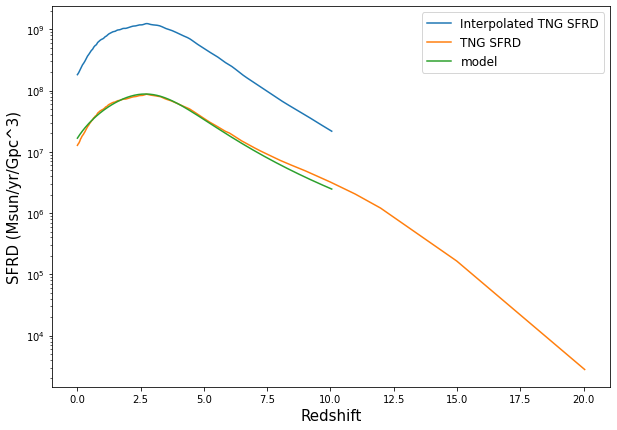

In [12]:
#Try plotting all three ways of getting SFR from data, and also the model
#Sum over Z and multiply the ones from data by step_fit_logZ to remove metallicity dependence
#Conclusion: the non-interpolated TNG SFRD matches the model
#But why would the interpolated SFRDnew not match model when that is what the model is fitted to?

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

plt.plot(redshift_new, np.sum(SFRDnew*step_fit_logZ*mpc,axis=0), label='Interpolated TNG SFRD') #interpolated Sim_SFRD
plt.plot(Redshifts, np.sum(Sim_SFRD*step_fit_logZ*mpc, axis=1), label='TNG SFRD') #using load_TNG
plt.plot(redshift_new, sfr, label='model')
plt.xlabel('Redshift', fontsize=15)
plt.ylabel('SFRD (Msun/yr/Gpc^3)', fontsize=15)
plt.yscale('log')
plt.legend(fontsize=12);
plt.savefig(paths.figures /'SFRD_z_comparisonTNG%s-%s.png'%(TNG,lvl))

In [13]:
# Interpolate the simulation data
f_interp = interpolate.interp2d(tofit_Sim_lookbackt, tofit_Sim_metals, tofit_Sim_SFRD.T, kind='cubic')
step_logZ =0.01

# Retrieve values at higher res regular intervals
redshift_COMPAS         = np.arange(0, 14.05, 0.05)
Lookbacktimes_COMPAS    = [cosmo.lookback_time(z).value for z in redshift_COMPAS]

log_tofit_Sim_metals = np.log10(tofit_Sim_metals)
metals_new           = np.logspace(min(log_tofit_Sim_metals), max(log_tofit_Sim_metals), 500) #500 metal values
log_metallicities_c = np.arange(-6, 0 + step_logZ, 0.01)
metallicities_c = 10**(log_metallicities_c)

SFRD_COMPAS = f_interp(Lookbacktimes_COMPAS,metals_new)
SFRD_COMPAS[SFRD_COMPAS < 0] = 0 #make sure there are no unphysical values of the SFRD

In [14]:
# Read out data
#np.savetxt(SFRD_Z_z_fname, SFRD_COMPAS)
#np.savetxt(metals_fname, metals_new)

# Check whether can read in data correctly
#SFRD_Z_z_test = np.loadtxt(SFRD_Z_z_fname)
#metallicities_test = np.loadtxt(metals_fname)

# Calculating SFRD(z) and dPdlogZ from TNG data

In [15]:
with h5.File(paths.data / str("SFRMetallicityFromGasWithMetalsTNG%s-%s.hdf5"%(TNG,lvl)), "r") as f:
        MetalBins     = f["MetalBins"][:]
        Lookbacktimes = f["Lookbacktimes"][:]
        BoxSfr        = f["Sfr"][:]
        Redshifts     = f["Redshifts"][:]
        Metals        = f["Metals"][:]

Sim_center_Zbin  = (MetalBins[:-1] + MetalBins[1:])/2.

# Convert SFR from sfr/box to sfr Mpc-3 <- need to then convert to Msun/yr/Gpc^3
littleh  = 0.6774
Rbox     = rbox/littleh
Sim_SFRD = BoxSfr / Rbox**3 *u.Mpc**-3
Sim_SFRD = Sim_SFRD.value

# The model comes in SFRD/DeltaZ, make sure your data does as well <- do NOT do this, otherwise multiply by step_fit_logZ
#step_fit_logZ  = np.diff(np.log(MetalBins))[0]    
#Sim_SFRD       = Sim_SFRD/step_fit_logZ

## SFRD(z)

In [16]:
#SFRD from model
sfr = find_sfr(Redshifts, a=sf_a, b=sf_b, c=sf_c, d=sf_d)

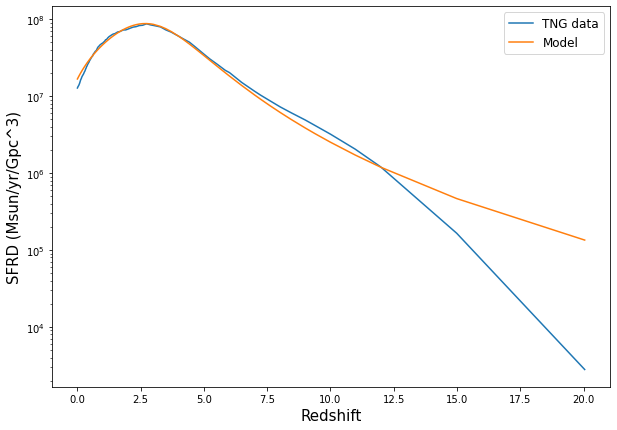

In [17]:
#Check which way of calculating SFRD is correct (with dividing by step_fit_logZ or without)
#Conclusion: withou

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.plot(Redshifts, np.sum(Sim_SFRD * mpc, axis=1), label='TNG data') #convert to Gpc^-3
plt.plot(Redshifts, sfr, label='Model')
plt.xlabel('Redshift', fontsize=15)
plt.ylabel('SFRD (Msun/yr/Gpc^3)', fontsize=15)
plt.yscale('log')
plt.legend(fontsize=12);
plt.savefig(paths.figures /"SFRD_z_fromTNG%s-%s_vsmodel.png"%(TNG,lvl))

## dPdlogZ

To calculate: for each COMPAS binary, have the redshift at which the binary formed and the metallicity of that binary. Find the closest metallicity (bin center) in the TNG data to the COMPAS metallicity. At the redshift at which the binary formed, find the metallicity distribution from the TNG data. Calculate the probability of getting that TNG metallicity value. That is the dPdlogZ for that binary (but actually do all this with logZ)

Note that I should check if COMPAS metallicity is in Zsolar units for when actually implementing into cosmic integration

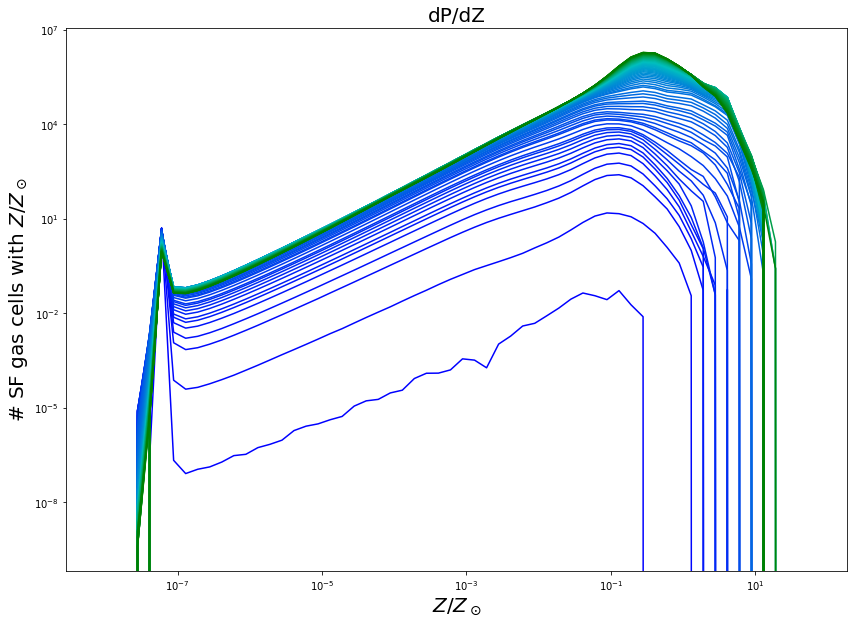

In [18]:
#Plot metallicity distribution for each redshift
#Blue to green = high z to low z

fig, ax = plt.subplots(figsize = (14,10))
for i in range(100):
    plt.plot(Sim_center_Zbin/Zsun, Metals[i]*Sim_center_Zbin, label='Snapshot %s' %i, c='%s'%colors[i])
plt.xscale('log')
plt.yscale('log')
plt.title('dP/dZ', fontsize=20)
plt.xlabel(r'$Z/Z_\odot$', fontsize=20)
plt.ylabel(r'# SF gas cells with $Z/Z_\odot$', fontsize=20)
#plt.legend();
plt.savefig(paths.figures /'dPdZ_TNG%s-%s.png'%(TNG, lvl))

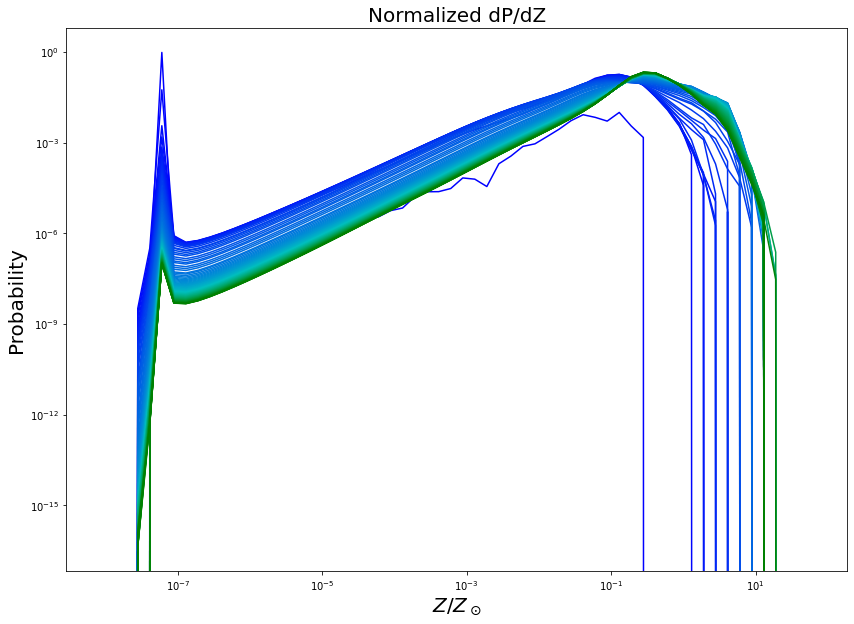

In [19]:
#Normalized metallicity distribution = probability of getting that Z at that redshift

fig, ax = plt.subplots(figsize = (14,10))
totalZ = np.trapz(Metals*Sim_center_Zbin)
for i in range(100):
    plt.plot(Sim_center_Zbin/Zsun, Metals[i]*Sim_center_Zbin/totalZ[i], label='Snapshot %s' %i, c='%s'%colors[i])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$Z/Z_\odot$', fontsize=20)
plt.ylabel(r'Probability', fontsize=20)
plt.title('Normalized dP/dZ', fontsize=20)
#plt.legend();
plt.savefig(paths.figures /'dPdZ_normalized_TNG%s-%s.png'%(TNG, lvl))

In [20]:
def calc_dPdlogZ(redshift_form, redshifts, binary_metallicity, data_metallicity, metallicity_dists, showdist=True):
    
    #find the redshift in the data that is the closest to the binary formation redshift
    z_ind = np.argmin(np.abs(redshifts - redshift_form)) #index
    z_form = redshifts[z_ind] #value of closest redshift 
    
    #convert everything to log metallicity
    binary_metallicity = np.log10(binary_metallicity)
    data_metallicity = np.log10(data_metallicity)
    #metallicity_dists = np.log10(metallicity_dists)
    #metallicity_dists[metallicity_dists==-np.inf] = 0
    
    #find closest value in the metallicities in the data to the binary metallicity
    metallicity_ind = np.argmin(np.abs(data_metallicity - binary_metallicity)) #index
    logmetallicity_form = data_metallicity[metallicity_ind] #value of closest metallicity
    metallicity_form = 10**data_metallicity[metallicity_ind] #value of closest metallicity
    
    #find the probability of getting that metallicity using the metallicity distribution at this redshift
    metal_dist_form = metallicity_dists[z_ind, :]
    norm_metal_dist_form = metal_dist_form/np.trapz(metal_dist_form)
    
    if showdist==True:
        plt.plot(data_metallicity, norm_metal_dist_form) #plot just to check
        #plt.xscale('log')
        plt.yscale('log')
        plt.show()
    
    total=0 #just to double check
    for i in norm_metal_dist_form:
        total += i
        
    print(z_form, metallicity_form, norm_metal_dist_form[metallicity_ind], total)
    
    return(z_form, metallicity_form, norm_metal_dist_form[metallicity_ind], total) 

In [21]:
def calc_dPdlogZ2(redshift_form, redshifts, binary_metallicity, data_metallicity, metallicity_dists, showdist=True):
    
    #find the redshift in the data that is the closest to the binary formation redshift
    z_ind = np.argmin(np.abs(redshifts - redshift_form)) #index
    z_form = redshifts[z_ind] #value of closest redshift 
    
    #convert everything to log metallicity
    binary_metallicity = np.log(binary_metallicity)
    data_metallicity = np.log(data_metallicity)
    #metallicity_dists = np.log10(metallicity_dists)
    #metallicity_dists[metallicity_dists==-np.inf] = 0
    
    #find closest value in the metallicities in the data to the binary metallicity
    metallicity_ind = np.argmin(np.abs(data_metallicity - binary_metallicity)) #index
    logmetallicity_form = data_metallicity[metallicity_ind] #value of closest metallicity
    metallicity_form = np.exp(data_metallicity)[metallicity_ind] #value of closest metallicity
    
    #find the probability of getting that metallicity using the metallicity distribution at this redshift
    metal_dist_form = metallicity_dists[z_ind, :]
    norm_metal_dist_form = metal_dist_form/np.trapz(metal_dist_form)
    
    if showdist==True:
        plt.plot(data_metallicity, norm_metal_dist_form) #plot just to check
        #plt.xscale('log')
        plt.yscale('log')
        plt.show()
    
    total=0 #just to double check
    for i in norm_metal_dist_form:
        total += i

    print(z_form, metallicity_form, norm_metal_dist_form[metallicity_ind], total)
    
    return(z_form, metallicity_form, norm_metal_dist_form[metallicity_ind], total) 

In [22]:
def calc_dPdlogZ_v2(redshift_form, redshifts, binary_metallicity, data_metallicity, metallicity_dists, showdist=False):
    
    #difference from v1: returns a 1D array of dPdlogZ values for each redshift - NOT at formation redshift
    #looks like this is what cosmic integration actually does
    
    dPdlogZs = []
    metals_form = []
    
    for z_ind, z in enumerate(redshifts):

        #convert everything to log metallicity
        binary_metallicity = np.log(binary_metallicity)
        data_metallicity = np.log(data_metallicity)
        #metallicity_dists = np.log10(metallicity_dists)
        #metallicity_dists[metallicity_dists==-np.inf] = 0
    
        #find closest value in the metallicities in the data to the binary metallicity
        metallicity_ind = np.argmin(np.abs(data_metallicity - binary_metallicity)) #index
        metallicity_form = data_metallicity[metallicity_ind] #value of closest metallicity
    
        #find the probability of getting that metallicity using the metallicity distribution at this redshift
        metal_dist_form = metallicity_dists[z_ind, :]
        norm_metal_dist_form = metal_dist_form/np.trapz(metal_dist_form)
        
        if showdist==True:
            plt.plot(data_metallicity, norm_metal_dist_form) #plot just to check
            #plt.xscale('log')
            plt.yscale('log')
            plt.show()
            
        dPdlogZs.append(norm_metal_dist_form[metallicity_ind])
        metals_form.append(metallicity_form)
    
    return(redshifts, metals_form, dPdlogZs) 

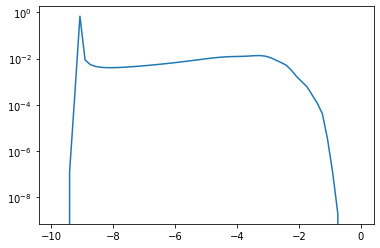

3.28303305795652 0.008406460345289803 0.0016591441345033165 0.9999999999999996


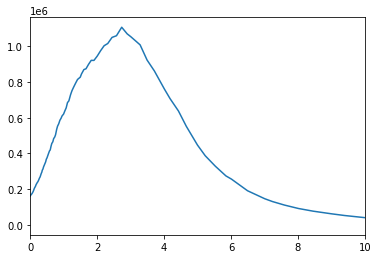

In [23]:
Average_SF_mass_needed = 0.13123123123
nformed = np.sum(Sim_SFRD*mpc, axis=1) / Average_SF_mass_needed
metallicities = Sim_center_Zbin
Sim_metals = Metals
Sim_redshifts = Redshifts
n_binaries = 1
COMPAS_metallicities = [1e-2]
z_of_formation = 3.3
formation_rate = np.zeros(shape=(n_binaries, len(Redshifts)))

for i in range(n_binaries):
    if len(Sim_metals) > 0:
        formation_rate[i, :] = nformed * calc_dPdlogZ(z_of_formation, Sim_redshifts, COMPAS_metallicities[i], \
        metallicities, Sim_metals)[2] #/ p_draw_metallicity * COMPAS_weights[i]
        plt.plot(Sim_redshifts, formation_rate[i])
        plt.xlim(0, 10)
    #else:
        # calculate formation rate (see Neijssel+19 Section 4) - note this uses dPdlogZ for *closest* metallicity
        #formation_rate[i, :] = n_formed * dPdlogZ[:, np.digitize(COMPAS_metallicites[i], metallicities)] 
        #/ p_draw_metallicity * COMPAS_weights[i]

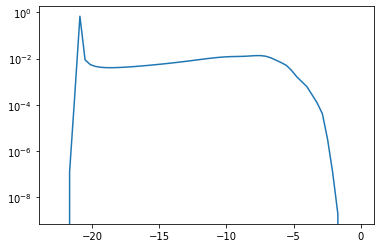

3.28303305795652 0.008406460345289806 0.0016591441345033165 0.9999999999999996


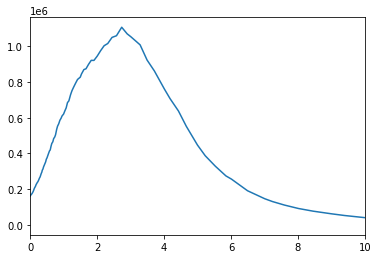

In [24]:
Average_SF_mass_needed = 0.13123123123
nformed = np.sum(Sim_SFRD*mpc, axis=1) / Average_SF_mass_needed
metallicities = Sim_center_Zbin
Sim_metals = Metals
Sim_redshifts = Redshifts
n_binaries = 1
COMPAS_metallicities = [1e-2]
z_of_formation = 3.3
formation_rate = np.zeros(shape=(n_binaries, len(Redshifts)))

for i in range(n_binaries):
    if len(Sim_metals) > 0:
        formation_rate[i, :] = nformed * calc_dPdlogZ2(z_of_formation, Sim_redshifts, COMPAS_metallicities[i], \
        metallicities, Sim_metals)[2] #/ p_draw_metallicity * COMPAS_weights[i]
        plt.plot(Sim_redshifts, formation_rate[i])
        plt.xlim(0, 10)
    #else:
        # calculate formation rate (see Neijssel+19 Section 4) - note this uses dPdlogZ for *closest* metallicity
        #formation_rate[i, :] = n_formed * dPdlogZ[:, np.digitize(COMPAS_metallicites[i], metallicities)] 
        #/ p_draw_metallicity * COMPAS_weights[i]

In [25]:
metallicities

array([1.23389963e-10, 1.81111698e-10, 2.65835618e-10, 3.90193325e-10,
       5.72725476e-10, 8.40646035e-10, 1.23389963e-09, 1.81111698e-09,
       2.65835618e-09, 3.90193325e-09, 5.72725476e-09, 8.40646035e-09,
       1.23389963e-08, 1.81111698e-08, 2.65835618e-08, 3.90193325e-08,
       5.72725476e-08, 8.40646035e-08, 1.23389963e-07, 1.81111698e-07,
       2.65835618e-07, 3.90193325e-07, 5.72725476e-07, 8.40646035e-07,
       1.23389963e-06, 1.81111698e-06, 2.65835618e-06, 3.90193325e-06,
       5.72725476e-06, 8.40646035e-06, 1.23389963e-05, 1.81111698e-05,
       2.65835618e-05, 3.90193325e-05, 5.72725476e-05, 8.40646035e-05,
       1.23389963e-04, 1.81111698e-04, 2.65835618e-04, 3.90193325e-04,
       5.72725476e-04, 8.40646035e-04, 1.23389963e-03, 1.81111698e-03,
       2.65835618e-03, 3.90193325e-03, 5.72725476e-03, 8.40646035e-03,
       1.23389963e-02, 1.81111698e-02, 2.65835618e-02, 3.90193325e-02,
       5.72725476e-02, 8.40646035e-02, 1.23389963e-01, 1.81111698e-01,
      

In [26]:
MetalBins

array([1.00000000e-10, 1.46779927e-10, 2.15443469e-10, 3.16227766e-10,
       4.64158883e-10, 6.81292069e-10, 1.00000000e-09, 1.46779927e-09,
       2.15443469e-09, 3.16227766e-09, 4.64158883e-09, 6.81292069e-09,
       1.00000000e-08, 1.46779927e-08, 2.15443469e-08, 3.16227766e-08,
       4.64158883e-08, 6.81292069e-08, 1.00000000e-07, 1.46779927e-07,
       2.15443469e-07, 3.16227766e-07, 4.64158883e-07, 6.81292069e-07,
       1.00000000e-06, 1.46779927e-06, 2.15443469e-06, 3.16227766e-06,
       4.64158883e-06, 6.81292069e-06, 1.00000000e-05, 1.46779927e-05,
       2.15443469e-05, 3.16227766e-05, 4.64158883e-05, 6.81292069e-05,
       1.00000000e-04, 1.46779927e-04, 2.15443469e-04, 3.16227766e-04,
       4.64158883e-04, 6.81292069e-04, 1.00000000e-03, 1.46779927e-03,
       2.15443469e-03, 3.16227766e-03, 4.64158883e-03, 6.81292069e-03,
       1.00000000e-02, 1.46779927e-02, 2.15443469e-02, 3.16227766e-02,
       4.64158883e-02, 6.81292069e-02, 1.00000000e-01, 1.46779927e-01,
      

[1.00000000e-10 1.46779927e-10 2.15443469e-10 3.16227766e-10
 4.64158883e-10 6.81292069e-10 1.00000000e-09 1.46779927e-09
 2.15443469e-09 3.16227766e-09 4.64158883e-09 6.81292069e-09
 1.00000000e-08 1.46779927e-08 2.15443469e-08 3.16227766e-08
 4.64158883e-08 6.81292069e-08 1.00000000e-07 1.46779927e-07
 2.15443469e-07 3.16227766e-07 4.64158883e-07 6.81292069e-07
 1.00000000e-06 1.46779927e-06 2.15443469e-06 3.16227766e-06
 4.64158883e-06 6.81292069e-06 1.00000000e-05 1.46779927e-05
 2.15443469e-05 3.16227766e-05 4.64158883e-05 6.81292069e-05
 1.00000000e-04 1.46779927e-04 2.15443469e-04 3.16227766e-04
 4.64158883e-04 6.81292069e-04 1.00000000e-03 1.46779927e-03
 2.15443469e-03 3.16227766e-03 4.64158883e-03 6.81292069e-03
 1.00000000e-02 1.46779927e-02 2.15443469e-02 3.16227766e-02
 4.64158883e-02 6.81292069e-02 1.00000000e-01 1.46779927e-01
 2.15443469e-01 3.16227766e-01 4.64158883e-01 6.81292069e-01
 1.00000000e+00]
61


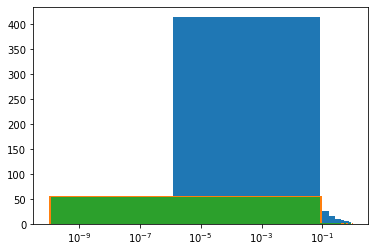

In [27]:
#sfr using interpolated z range
sfr2 = find_sfr(redshift_new, a=sf_a, b=sf_b, c=sf_c, d=sf_d)
minlogZ = np.log(MetalBins[0])
maxlogZ = np.log(MetalBins[-1])
steplogZ = (maxlogZ-minlogZ)/len(Sim_center_Zbin)

minlogZ2 = np.log(MetalBins[0])
maxlogZ2 = np.log(MetalBins[-1])
steplogZ2 = (maxlogZ-minlogZ)/len(Sim_center_Zbin)

#using interpolated Z, z range
dPdlogZ1, metallicities1, step_logZ1, p_draw_metallicity1 = find_metallicity_distribution(redshift_new, metals = metals_new,
                                  mu_0=mu0, mu_z=muz, sigma_0=omega0, sigma_z=omegaz, alpha =alpha0,
                                  min_logZ=minlogZ, max_logZ=maxlogZ, step_logZ =steplogZ)

#calculating Z from min, max, and step logZ
dPdlogZ3, metallicities3, step_logZ3, p_draw_metallicity3 = find_metallicity_distribution(Redshifts,
                                  mu_0=mu0, mu_z=muz, sigma_0=omega0, sigma_z=omegaz, alpha =alpha0,
                                  min_logZ=minlogZ, max_logZ=maxlogZ, step_logZ =steplogZ)

#using Z, z range directly from TNG data
dPdlogZ2, metallicities2, step_logZ2, p_draw_metallicity2 = find_metallicity_distribution(Redshifts, metals = metallicities,
                                  mu_0=mu0, mu_z=muz, sigma_0=omega0, sigma_z=omegaz, alpha =alpha0,
                                  min_logZ=minlogZ, max_logZ=maxlogZ, step_logZ =steplogZ)

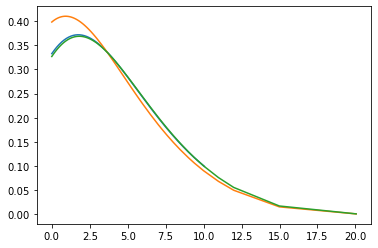

In [28]:
#dPdlogZ calculared three ways; supposedly should give the same (or approx the same) result
plt.plot(redshift_new, dPdlogZ1[:, np.digitize(COMPAS_metallicities[0], metals_new)]);
plt.plot(Redshifts, dPdlogZ2[:, np.digitize(COMPAS_metallicities[0], metallicities)]);
plt.plot(Redshifts, dPdlogZ3[:, np.digitize(COMPAS_metallicities[0], metallicities)]);

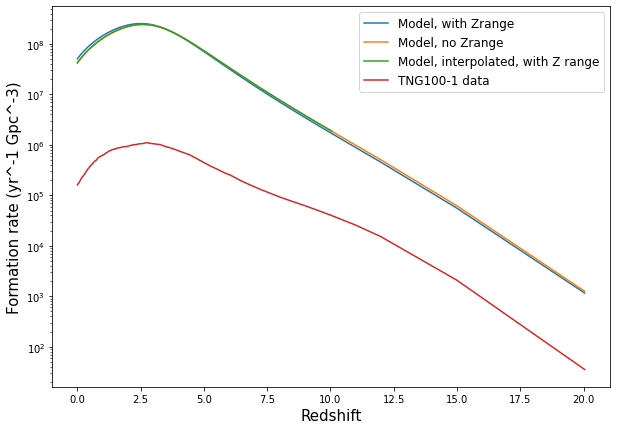

In [29]:
# Formation rate using model and using the data
# should at least be the same order of magnitude
# looks like there is a normalization factor difference..

fig, ax = plt.subplots(figsize = (10,7))

model_form_rate = np.zeros(shape=(n_binaries, len(Redshifts)))
model_form_rate[0, :] = sfr/Average_SF_mass_needed * dPdlogZ2[:, np.digitize(COMPAS_metallicities[0], metallicities)]

model_form_rate2 = np.zeros(shape=(n_binaries, len(Redshifts)))
model_form_rate2[0, :] = sfr/Average_SF_mass_needed * dPdlogZ3[:, np.digitize(COMPAS_metallicities[0], metallicities)]

model_form_rate3 = np.zeros(shape=(n_binaries, len(redshift_new)))
model_form_rate3[0, :] = sfr2/Average_SF_mass_needed * dPdlogZ1[:, np.digitize(COMPAS_metallicities[0], metals_new)]


plt.plot(Redshifts, model_form_rate[0], label='Model, with Zrange')
plt.plot(Redshifts, model_form_rate2[0], label='Model, no Zrange')
plt.plot(redshift_new, model_form_rate3[0], label='Model, interpolated, with Z range')
plt.plot(Sim_redshifts, formation_rate[0], label='TNG%s-%s data'%(TNG, lvl))
plt.yscale('log')
plt.xlabel('Redshift', fontsize=15)
plt.ylabel('Formation rate (yr^-1 Gpc^-3)', fontsize=15)
plt.legend(fontsize=12)
plt.savefig(paths.figures /'formrate_modelvsdataTNG%s-%s'%(TNG, lvl))

## dPdlogZ issues

1. dPdlogZ vs dPdZ
    - From what I understand: since the metallicity bins are spaced out in logspace (np.logspace = base log10!! make sure consistent later too, this feels like a possible source of issue), this means that the metallicity distributions are already logZ (again note base 10 vs base e)
    - This means that when evaluating dPdlogZ, I need the logZ of the COMPAS binary metallicity, and logZ of the centers of the redshift bins in the TNG data (Sim_center_Zbin). Then at the associated redshift, the metallicity distribution should alreay be in logZ, so find probability of getting the closest log(Sim_center_Zbin) to the log(COMPAS binary metallicity) in that metallicity distribution. 
    - Expected result: same approximate shape and same order of magnitude of the merger rate as when using the model dPdlogZ
    - However, merger rates are currently 1-2 orders of magnitude lower than what I get from the model. The discrepancy is worse when using the (more likely correct) dPdlogZ version in which I do not take the log of the metallicity distribution (e.g. histogram) values
    

2. Evaluate dPdlogZ at all redshifts, not at formation redshift
    - calc_dPdlogZ vs calc_dPdlogZ_v2, original evaluates it specifically at the formation redshift of the binary. However, it looks like in COMPAS cosmic integration, it evaluates dPdlogZ for all redshifts for that binary (finds the probability of getting that binary metallicity at all redshifts?), which is then convolved with the SFR
    - Expected result: 1D array of dPdlogZ values, for which v2 is needed
    

3. Is the model cosmic integration version even correct?
    - When fitting the model to the TNG data, dPdlogZ is calculated for the array of metallicities (Sim_center_Zbin). In COMPAS cosmic integration, there is no option to put in an array of metallicities; instead it calculates the metallicity range ***using np.arange*** between **natural** log(min Z) and log(max Z). From the TNG data, the bins were calculated using np.logspace which uses log base 10. 
    - When trying to calculate it both ways in this notebook, the plot of dPdlogZ has a **completely different shape** when calculated using an input array of metallicities vs creating one from a min, max, and step. Not sure if something is going wrong where I'm doing it in this notebook or these actually produce different things vs the logs issue
    - Likely need to check what dPdlogZ looks like when running actual cosmic integration, to see what I expect here
    - Source of concern: if the dPdlogZ which is fitted to the data is a completely different shape from the dPdlogZ which cosmic integration uses to calculate the merger rates, can we even trust the output of cosmic integration? Is it even using the model correctly? To check this, probably a good idea to plot dPdlogZ **and** calculate and plot SFRD(Z, z) in cosmic integration. 

## Next steps

0. Read Ruediger's paper to consider Pop III contribution to low Z peak
1. Try changing dPdlogZ function to use log10, see if it fixes the extreme differences between dPdlogZ calculated with a metallicity array vs without
2. Check if cosmic integration uses log10 elsewhere
3. Try cosmic integration with plotting dPdlogZ to check what shape I should expect
4. Try multiplying SFRD(z) by either number of bins or bin width to see if that fixes the normalization factor difference when interpolating. Also maybe just get rid of that whole other interpolation thing I was trying while trying to use SFRD(Z, z). 
5. Try running multiple the full calculation of the formation rate in cosmic integration using TNG data

It looks like everything in COMPAS and the analytical model fit are in log not log10  <- seems like an odd choice to me but it seems consistent - no log10s or logspace in cosmic integration

- Might need to redo the fitting once try out one dataset with logZ not log10Z
- Try out TNG50 vs TNG100 for the appearance of the peak at low Z <- based on Ruediger's paper on low metallicity star formation in TNG50, resolution may cause more low Z star formation at low z
- Ask Lieke about the log vs log10 thing
- Ask Ruediger about his thoughts on that peak

In [30]:
import ClassCOMPAS

In [31]:
# read in COMPAS data and check if metallicity is log10 or ln spaced

COMPASpath = '/Users/sashalvna/research/Fit_SFRD_TNG/data/'
COMPASfilename = 'COMPAS_Output_wWeights.h5'

COMPAS = ClassCOMPAS.COMPASData(COMPASpath, fileName=COMPASfilename, Mlower=5*u.Msun, Mupper=150*u.Msun, m2_min=0.1*u.Msun, binaryFraction=0.7, suppress_reminder=True)
COMPAS.setCOMPASDCOmask(types="BBH", withinHubbleTime=True, pessimistic=True, noRLOFafterCEE=True)
COMPAS.setCOMPASData()
COMPAS.set_sw_weights('mixture_weight')
COMPAS.find_star_forming_mass_per_binary_sampling()

noRLOFafterCEE, pessimistic: True True
sum(type_masks[BBH]) 2273376, sum(hubble_mask) 1835145, sum(rlof_mask) 2523122, sum(pessimistic_mask) 2523122


In [32]:
assert np.log(np.min(COMPAS.initialZ)) != np.log(np.max(COMPAS.initialZ))

In [33]:
chirp_masses = (COMPAS.mass1*COMPAS.mass2)**(3/5) / (COMPAS.mass1 + COMPAS.mass2)**(1/5)
etas = COMPAS.mass1 * COMPAS.mass2 / (COMPAS.mass1 + COMPAS.mass2)**2
n_binaries = len(chirp_masses)

In [34]:
n_binaries

1640550

In [35]:
mbins1 = np.logspace(-10, 0, 60, base=10)
mbins2 = np.logspace(-23, 0, 60, base=np.e)

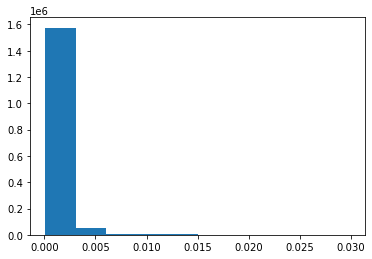

In [36]:
plt.hist(COMPAS.metallicitySystems); #metallicity of the actual binaries

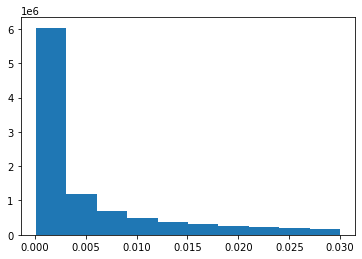

In [37]:
plt.hist(COMPAS.initialZ); #metallicity distribution that binary metallicities are selected from?

In [38]:
len(COMPAS.metallicitySystems)

1640550

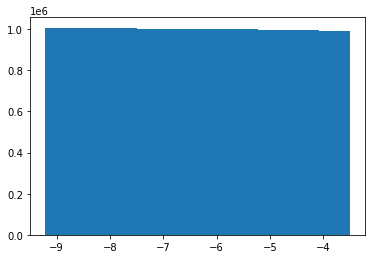

In [39]:
plt.hist(np.log(COMPAS.initialZ));

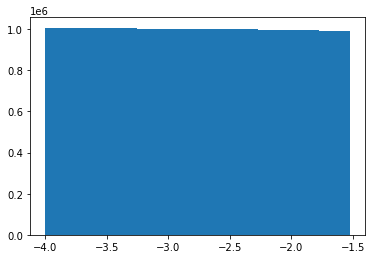

In [40]:
plt.hist(np.log10(COMPAS.initialZ));

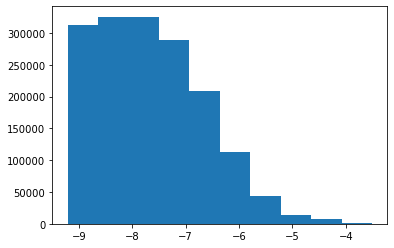

In [41]:
plt.hist(np.log(COMPAS.metallicitySystems));